# Plasmonic waveguide sensor for carbon dioxide detection

**Note: the cost of running the entire notebook is about 10 FlexCredits.**

Dielectric waveguides made of materials like silicon and other semiconductors have been well-known in integrated photonics to guide light with low loss. Plasmonic waveguides made of metals like silver and gold are another promising platform for nanoscale photonic applications relying on the use of surface plasmon polaritons (SPPs) to strongly confine and guide light. This tight field confinement leads to enhanced light-matter interactions, opening up applications in sensing, nanolasing, and quantum optics. Plasmonic waveguides such as metal-insulator-metal, insulator-metal-insulator, and metallic nanowires exhibit deep-subwavelength optical modes but also suffer from intrinsic losses due to metal absorption. Nonetheless, the combination of strong field confinement and sensitivity to surface conditions provides the potential for integrated nanophotonic devices and sensors based on plasmonic waveguides.

In this notebook, we model a plasmonic sensor for CO$_2$ concentration detection. The sensor is based on a metal-insulator-metal (MIM) waveguide coupled to a square ring cavity. The square ring cavity is filled with a polymer called polyhexamethylene biguanide (PHMB), which is sensitive to CO$_2$. When CO$_2$ is present, it causes a change in the refractive index of the PHMB, which shifts the resonant wavelength of the sensor. This shift can be used to detect and quantify the CO$_2$ concentration over a range of 0 - 524 ppm, which covers atmospheric concentrations relevant to climate change monitoring. The design is based on the work `S. N. Khonina, N. L. Kazanskiy, M. A. Butt, A. Kaźmierczak, and R. Piramidowicz, "Plasmonic sensor based on metal-insulator-metal waveguide square ring cavity filled with functional material for the detection of CO2 gas," Opt. Express 29, 16584-16594 (2021)` [DOI:10.1364/OE.423141](https://doi.org/10.1364/OE.423141).

<img src="img/mim_co2_sensor.png" width=400 alt="schematic of the MIM sensor">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## Simulation Setup 

Define the simulation wavelength range to be 1.1 μm  to 1.6 μm.

In [2]:
lda0 = 1.35  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.1, 1.6, 301)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency

Four materials will be used in the simulation: gold, SiO$_2$, air, and the polymer PHMB. Gold is given by the [Drude](../_autosummary/tidy3d.Drude.html) model with the parameters taken from the [reference](https://doi.org/10.1364/OE.423141). SiO$_2$ is directly defined from the [material library](../material_library.html). Air has a constant permittivity of 1. PHMB has a refractive index sensitive to the CO$_2$ concentration, which will be investigated in a parameter sweep, so we will define the PHMB medium later.

In [3]:
# define gold medium
au = td.Drude(eps_inf=9.0685, coeffs=[(135.44e14 / (2 * np.pi), 1.15e14 / (2 * np.pi))])

# define sio2 medium
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

# define air medium
air = td.Medium(permittivity=1)

Define the geometric parameters of the sensor. These values have been optimized in the [reference](https://doi.org/10.1364/OE.423141). If further optimization is needed, [parameter sweeps](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan/) or [adjoint optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/) can be applied.

In [4]:
L = 0.6  # side length of the square cavity
g = 0.01  # gap size between the bus waveguide and the square cavity
W1 = 0.09  # width of the square cavity waveguide
W = 0.06  # width of the bus waveguide
H = 0.7  # thickness of the gold layer
inf_eff = 1e2  # effective infinity of the simulation

Define the structures of the sensor, which consists of the SiO$_2$ substrate, a gold layer, a bus waveguide filled with air, and a square ring cavity. The ring cavity is filled with PHMB. Therefore, we will define an outer square with PHMB and an inner square with gold. The outer square will be defined later with the PHMB medium.

In addition, we define a mesh override structure around the bus waveguide and square cavity such that the grid will be refined in this region. Since we want to accurately capture the resonance of the device, using a fine grid is important. The refractive index of the mesh override structure is set to 20.

In [5]:
# define the substrate structure
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# define the gold layer structure on top of the substrate
au_layer = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, H)), medium=au
)

# define the air-filled bus waveguide structure
bus_waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-W / 2, -inf_eff, 0), rmax=(W / 2, inf_eff, H)), medium=air
)

# define the inner square cavity structure
ring_cavity_inner = td.Structure(
    geometry=td.Box(center=(W / 2 + g + L / 2, 0, H / 2), size=(L - 2 * W1, L - 2 * W1, H)),
    medium=au,
)

# define the region where grid will be refined
refine_structure = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-W / 2, -L / 2, 0), rmax=(W / 2 + g + L, L / 2, H)),
    medium=td.Medium(permittivity=20**2),
)

Define simulation domain size, run time, source, and monitors. Since the plasmonic waveguide sensor has a small footprint and the field is mostly confined inside the waveguide, the simulation domain only needs to be slightly larger than the device itself. 

To excite the bus waveguide, a [ModeSource](../_autosummary/tidy3d.ModeSource.html) is used, similar to simulating a dielectric waveguide. A [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) is defined at the other end of the bus waveguide to compute transmission. To visualize the field distribution, we also add a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) at `z=H/2`. This monitor will record the fields at two frequencies, the minimum frequency and the central frequency. The minimum frequency is off-resonant and the central frequency is close to being on-resonant.

In [6]:
buffer = lda0 / 2  # buffer length in each direction

# define simulation domain size
Lx = L + buffer
Ly = L + g + W + buffer
Lz = H + buffer

run_time = 1.5e-13  # simulation run time

# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=2)
mode_source = td.ModeSource(
    center=(0, -L / 2 - lda0 / 4, H / 2),
    size=(4 * W, 0, 3 * H),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=5,
)

# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(0, L / 2 + lda0 / 4, H / 2),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add a field monitor to visualize field distribution at z=H/2
field_monitor = td.FieldMonitor(
    center=(0, 0, H / 2), size=(td.inf, td.inf, 0), freqs=[np.min(freqs), freq0], name="field"
)

[08:59:14] WARNING: Default value for the field monitor           ]8;id=304375;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\monitor.py\monitor.py]8;;\:]8;id=815458;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

To facilitate a parameter sweep to simulate different CO$_2$ concentrations, we will define a function `make_sim(n_phmb)`, which returns a `Tidy3D` [Simulation](../_autosummary/tidy3d.Simulation.html) given the refractive index of PHMB. Since the simulation domain is small, if we use the PML boundary condition, we will receive warnings about structures being too close to the boundary. To avoid this warning, we use the [Absorber](../_autosummary/tidy3d.Absorber.html) boundary condition, which will work perfectly fine in this case. PML should be placed sufficiently far from any structures since evanescent field leaking into PML could cause the simulation to diverge. [Absorber](../_autosummary/tidy3d.Absorber.html), on the other hand, does not have this concern.

In [7]:
def make_sim(n_phmb):

    # define the phmb medium
    phmb = td.Medium(permittivity=n_phmb**2)

    # define the outer square cavity structure
    ring_cavity_outer = td.Structure(
        geometry=td.Box(center=(W / 2 + g + L / 2, 0, H / 2), size=(L, L, H)), medium=phmb
    )

    # define simulation
    sim = td.Simulation(
        center=(W / 2 + g + L / 2, 0, H / 2),
        size=(Lx, Ly, Lz),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=30, wavelength=lda0, override_structures=[refine_structure]
        ),
        structures=[substrate, au_layer, bus_waveguide, ring_cavity_outer, ring_cavity_inner],
        sources=[mode_source],
        monitors=[mode_monitor, field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.Absorber()),
    )
    return sim

To test our `make_sim` function, we define a simulation and visualize it.

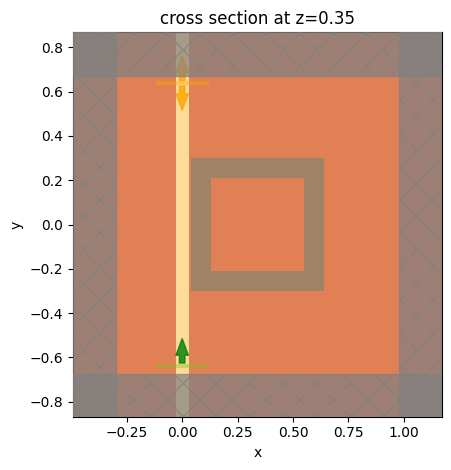

In [8]:
sim = make_sim(1.55)
sim.plot(z=H / 2)
plt.show()

We further visualize the grid around the cavity region to ensure it's sufficiently fine.

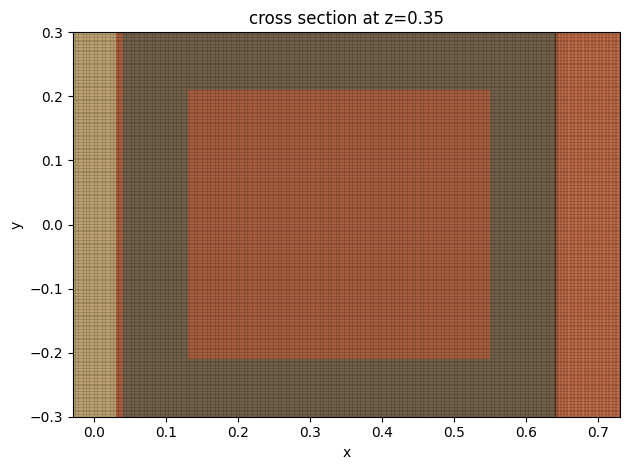

In [9]:
ax = sim.plot(z=H / 2)
sim.plot_grid(z=H / 2, ax=ax)
ax.set_xlim(-W / 2, W / 2 + g + W1 + L)
ax.set_ylim(-L / 2, L / 2)
ax.set_aspect("auto")
plt.show()

Before running the simulations, we can use the [ModeSolver](../_autosummary/tidy3d.plugins.mode.ModeSolver.html) plugin to visualize the source mode to ensure we are launching the plasmonic waveguide mode. 

In [10]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=mode_source.center, size=mode_source.size),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

[08:59:16] WARNING: Use the remote mode solver with subpixel  ]8;id=691666;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\plugins\mode\mode_solver.py\mode_solver.py]8;;\:]8;id=226633;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\plugins\mode\mode_solver.py#154\154]8;;\
           averaging for better accuracy through                                
           'tidy3d.plugins.mode.web.run(...)'.                                  

After running the solver, we can visualize the mode field. Indeed we see the plasmonic waveguide mode with the field concentrated inside the bus waveguide.

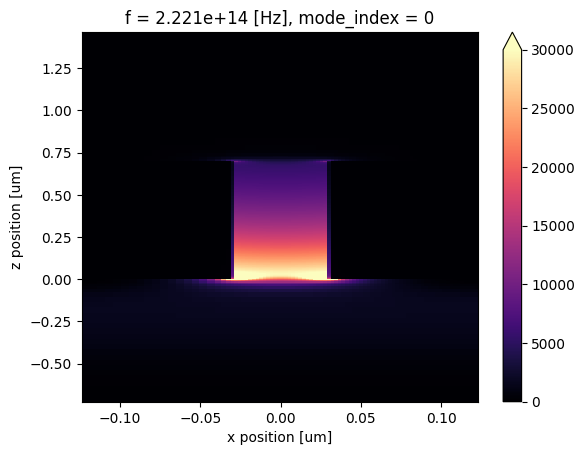

In [11]:
mode_data.intensity.plot(x="x", y="z", cmap="magma", vmin=0, vmax=3e4)
plt.show()

Lastly, we can estimate the cost of running this single simulation, which will give us a better idea of the cost of running a batch of simulations.

In [12]:
job = web.Job(simulation=sim, task_name="plasmonic_sensor")
estimated_cost = web.estimate_cost(job.task_id)

[08:59:27] Created task 'plasmonic_sensor' with task_id            ]8;id=79946;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=220512;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1'.                       

           View task using web UI at                               ]8;id=461804;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=135649;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=401823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=519726;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1\taskId]8;;\]8;id=401823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1\=]8;;\]8;id=659999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1\fdve]8;;\]8;id=401823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1\-]8;;\              
           ]8;id=401823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1\dc128cb3-c2f8-4bf2-9440-9816e5adeb0av1']8;;\.                             

Output()

The estimated maximum cost is 2.633 Flex Credits.


## Running the Parameter Sweep 

Now that everything is set up correctly, we are ready to run a parameter sweep to investigate the transmission spectra at different PHMB refractive index values corresponding to different CO$_2$ concentrations. For the concentration in the range of 0 ppm to 524 ppm, the refractive index varies linearly from 1.55 to 1.48.

In [13]:
# refractive index values to be simulated
n_phmb_array = np.array([1.48, 1.51, 1.53, 1.55])

# define a simulation batch
sims = {f"n_phmb={n_phmb:.2f}": make_sim(n_phmb) for n_phmb in n_phmb_array}

batch = web.Batch(simulations=sims)

# run the batch
batch_results = batch.run(path_dir="data")

[08:59:36] Created task 'n_phmb=1.48' with task_id                 ]8;id=384627;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=670264;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1'.                       

           View task using web UI at                               ]8;id=49676;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=973579;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=165295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=221727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1\taskId]8;;\]8;id=165295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1\=]8;;\]8;id=281279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1\fdve]8;;\]8;id=165295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1\-]8;;\              
           ]8;id=165295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1\586fb1e0-6257-47fc-9647-1834a9d21b09v1']8;;\.                             

Output()

[08:59:38] Created task 'n_phmb=1.51' with task_id                 ]8;id=716577;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=733922;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1'.                       

           View task using web UI at                               ]8;id=916947;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=132356;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=603933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=773761;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1\taskId]8;;\]8;id=603933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1\=]8;;\]8;id=306312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1\fdve]8;;\]8;id=603933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1\-]8;;\              
           ]8;id=603933;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1\2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1']8;;\.                             

Output()

[08:59:39] Created task 'n_phmb=1.53' with task_id                 ]8;id=200436;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=285472;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1'.                       

           View task using web UI at                               ]8;id=514073;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=771231;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=888856;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=993140;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1\taskId]8;;\]8;id=888856;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1\=]8;;\]8;id=151356;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1\fdve]8;;\]8;id=888856;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1\-]8;;\              
           ]8;id=888856;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1\67c1ce7b-8a42-400b-92e8-43b03731d64ev1']8;;\.                             

Output()

[08:59:41] Created task 'n_phmb=1.55' with task_id                 ]8;id=349909;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=384405;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1'.                       

           View task using web UI at                               ]8;id=99336;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=890691;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=908203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=379706;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1\taskId]8;;\]8;id=908203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1\=]8;;\]8;id=640193;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1\fdve]8;;\]8;id=908203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1\-]8;;\              
           ]8;id=908203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1\e7236603-b480-4138-9a29-0a54a5d9d9dav1']8;;\.                             

Output()

[08:59:46] Started working on Batch.                            ]8;id=888529;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=191317;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#475\475]8;;\

[08:59:49] Maximum FlexCredit cost: 10.531 for the whole batch. ]8;id=875313;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=45025;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[09:02:35] Batch complete.                                      ]8;id=338319;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=619140;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#522\522]8;;\

After running the parameter sweep, we can check the actual FlexCredit cost.

In [14]:
real_cost = batch.real_cost()

The actual FlexCredit cost is 9.899322401520688.


## Result Visualization 

After the simulations are complete, we can plot the transmission spectra at different PHMB refractive index values. We see a significant blueshift of the resonant wavelength as the refractive index decreases from 1.55 to 1.48. Therefore, we can use the resonance wavelength to determine the concentration of CO$_2$.

Output()

[09:02:43] loading SimulationData from                             ]8;id=270845;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=75155;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-586fb1e0-6257-47fc-9647-1834a9d21b09v1.hdf5                

Output()

[09:02:49] loading SimulationData from                             ]8;id=183725;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=922132;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1.hdf5                

Output()

[09:02:55] loading SimulationData from                             ]8;id=629924;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=332446;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-67c1ce7b-8a42-400b-92e8-43b03731d64ev1.hdf5                

Output()

[09:03:02] loading SimulationData from                             ]8;id=282293;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=372285;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-e7236603-b480-4138-9a29-0a54a5d9d9dav1.hdf5                

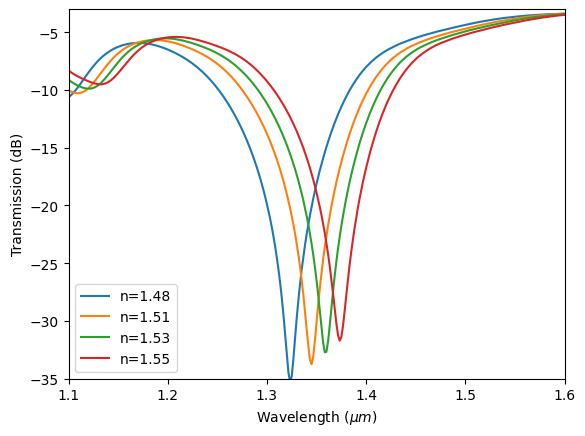

In [15]:
for n_phmb in n_phmb_array:
    sim_data = batch_results[f"n_phmb={n_phmb:.2f}"]
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="+")
    T = np.abs(amp) ** 2
    plt.plot(ldas, 10 * np.log10(T), label=f"n={n_phmb}")

plt.legend()
plt.xlim(np.min(ldas), np.max(ldas))
plt.ylim(-35, -3)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission (dB)")
plt.show()

Finally, we plot the field ($H_z$) distributions on- and off-resonance. When it's off-resonance, we see a high transmission of the plasmonic waveguide mode while a low transmission when it's on resonance, consistent with the spectra above.

[09:03:03] loading SimulationData from                             ]8;id=391175;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=539826;file://C:\Users\xinzh\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#591\591]8;;\
           data\fdve-2b6f5d9f-9c8d-4471-bffa-e727ef6d9d8fv1.hdf5                

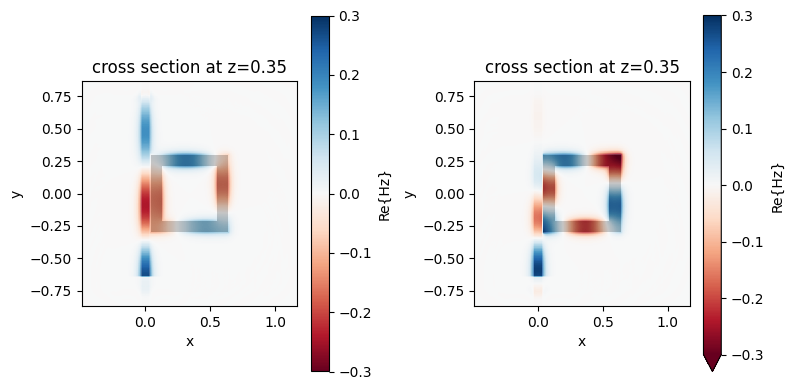

In [16]:
sim_data = batch_results[f"n_phmb=1.51"]
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim_data.plot_field(
    field_monitor_name="field",
    field_name="Hz",
    val="real",
    ax=ax1,
    f=np.min(freqs),
    vmin=-0.3,
    vmax=0.3,
)
sim_data.plot_field(
    field_monitor_name="field", field_name="Hz", val="real", ax=ax2, f=freq0, vmin=-0.3, vmax=0.3
)
plt.show()

To fully characterize the performance of a refractive index sensor, one can perform further quantitative analysis on the resonance wavelength shift and compute quantities like the sensitivity. For the sake of simplicity, we will not delve into it in this notebook.